In [39]:
import dask_image.imread
import dask_image.ndmeasure
import dask.array as da

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Data loading

first we load all images in a dask array each chuck of this dask array is a flower image.

In [40]:
path = os.path.join('../../data/flower_images/', '*.png')
flowers_chunck = dask_image.imread.imread(path)

#visualize the dask array
flowers_chunck

,Array,Chunk
Bytes,13.76 MB,65.54 kB
Shape,"(210, 128, 128, 4)","(1, 128, 128, 4)"
Count,210 Tasks,210 Chunks
Type,uint8,numpy.ndarray


### Grayscale stage

We start with the grayscale transformation which is basicly gathering in one dimension the rgb dimensions with according scaling of the original image. 

In [41]:
#luminance equation for the grayscale
def grayscale(rgb_img):
    result = ((rgb_img[..., 0] * 0.2125) +
              (rgb_img[..., 1] * 0.7154) +
              (rgb_img[..., 2] * 0.0721))
    return result

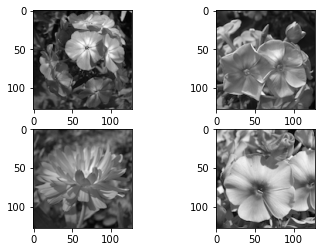

In [42]:
# we apply to the chu
gray_flowers = grayscale(flowers_chunck)


fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].imshow(gray_flowers[0], cmap="gray")
ax[0,1].imshow(gray_flowers[1], cmap="gray")
ax[1,0].imshow(gray_flowers[2], cmap="gray")
ax[1,1].imshow(gray_flowers[3], cmap="gray")
plt.show()

### Segmentation stage

to segment a grayscale image we only need to set a <b>threshold</b> that will separate the bright pixels from the darkest. the % to keep must be declared in the argument portion.
Since we want to apply the segmentation to every image independently, we will use the fonction <b>map_block</b> that apply a function to every block (i.e image) of the dask array.

In [43]:
def segmentation(gray_img_bloc, portion):
    return gray_img_bloc > (portion * gray_img_bloc.max())

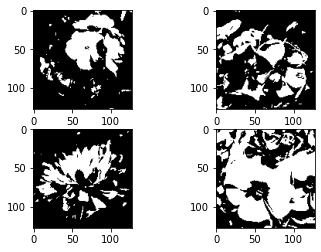

In [44]:
# we map this function to all the flowers
segmented_flowers = gray_flowers.map_blocks(segmentation, 0.5)


fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].imshow(segmented_flowers[0], cmap="gray")
ax[0,1].imshow(segmented_flowers[1], cmap="gray")
ax[1,0].imshow(segmented_flowers[2], cmap="gray")
ax[1,1].imshow(segmented_flowers[3], cmap="gray")
plt.show()

### Labelisation

To labelise our images we use the function <b>label()</b> (from dask_image.ndmeasure) that return a unique label for every connected part in the image. We may choose the complexity of the connection structure but here we will leave to the automatic mode.  

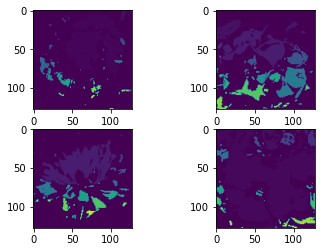

In [45]:
relabeled_flowers = segmented_flowers.map_blocks(lambda x: dask_image.ndmeasure.label(x)[0])

fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].imshow(relabeled_flowers[0])
ax[0,1].imshow(relabeled_flowers[1])
ax[1,0].imshow(relabeled_flowers[2])
ax[1,1].imshow(relabeled_flowers[3])
plt.show()

### Histogram Plot

know we just need to compute the number of labels per image. for that we just detect the highest label Id according to the 2axes per images and we group all the results in an array. 

Then we plot the histogram of that array

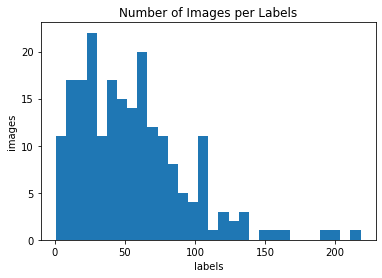

In [46]:
hist_label = relabeled_flowers.max(axis=(1,2)).compute()
plt.hist(hist_label, bins=30)
plt.xlabel("labels")
plt.ylabel("images")
plt.title("Number of Images per Labels");

